In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from neuralprophet import NeuralProphet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import shap
import warnings
shap.initjs()
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定するよ
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

In [103]:
def rmse(y_true, y_pred):

    return np.sqrt(mse(y_true, y_pred))

### トレンド成分のみ取り出してProphetで予測してみる

In [104]:
df = pd.read_csv('train_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)
df_test = pd.read_csv('test_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)

In [105]:
def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df = format_date_time(df)
df_test = format_date_time(df_test)

In [106]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
target_names = ['CO', 'C6H6', 'NOx']
features = df.columns.to_list()
features.remove('date_time')
#features.remove('day_of_week')
#features.remove('working_hours')

for i in targets:
    features.remove(i)

In [107]:
def targets_stl(df):

    for i in range(3):

        stl = STL(df[targets[i]].values, period=24, robust=True)
        stl_series = stl.fit()

        df[targets[i]] = stl_series.trend
    
    return df

def features_stl(df):

    for i in tqdm(range(len(features))):

        stl = STL(df[features[i]].values, period=24, robust=True)
        stl_series = stl.fit()
    
        df[features[i]] = stl_series.trend
    
    return df

In [108]:
df_trend = df.copy()

df_trend = targets_stl(df_trend)
df_trend = features_stl(df_trend)


100%|██████████| 129/129 [01:00<00:00,  2.14it/s]


トレンド成分のグラフ

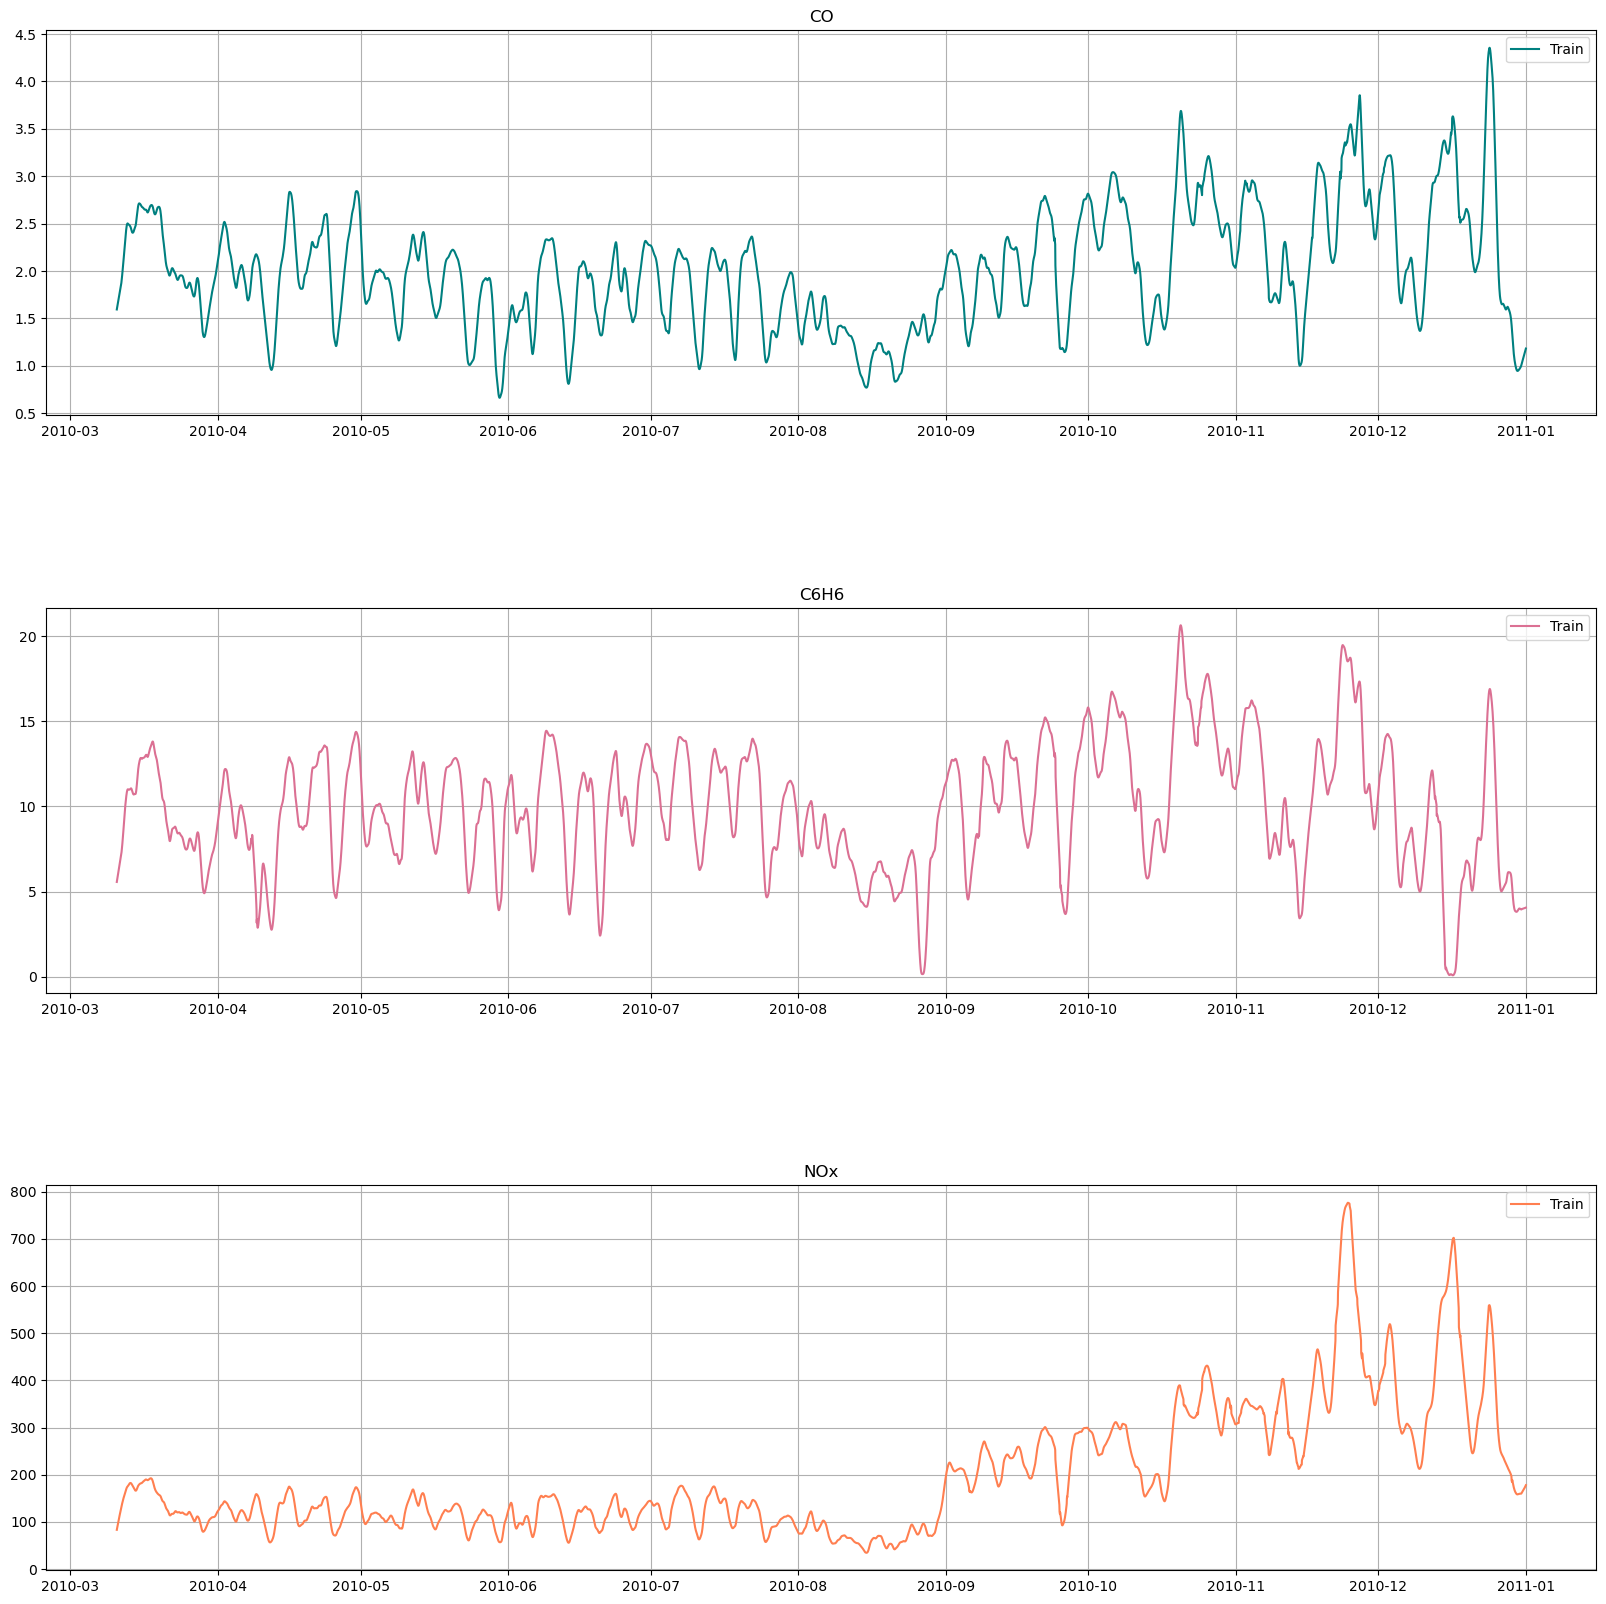

In [109]:
colors = ['teal', 'palevioletred', 'coral']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    axs[i].plot(df_trend['date_time'], df_trend[targets[i]], color=colors[i], label='Train')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

In [110]:
df_trend_CO = df_trend.drop([targets[1], targets[2]], axis=1)
df_trend_C6H6 = df_trend.drop([targets[0], targets[2]], axis=1)
df_trend_NOx = df_trend.drop([targets[0], targets[1]], axis=1)

In [111]:
df_trend_CO = df_trend_CO.rename(columns={'date_time': 'ds', targets[0]: 'y'})
df_trend_C6H6 = df_trend_C6H6.rename(columns={'date_time': 'ds', targets[1]: 'y'})
df_trend_NOx = df_trend_NOx.rename(columns={'date_time': 'ds', targets[2]: 'y'})

In [112]:
df_trend_CO_train, df_trend_CO_val = train_test_split(df_trend_CO, test_size=0.2, shuffle=False)
df_trend_C6H6_train, df_trend_C6H6_val = train_test_split(df_trend_C6H6, test_size=0.2, shuffle=False)
df_trend_NOx_train, df_trend_NOx_val = train_test_split(df_trend_NOx, test_size=0.2, shuffle=False)

In [113]:
model_CO = Prophet()

for i in tqdm(range(len(features))):

    model_CO.add_regressor(features[i])


model_C6H6 = Prophet()

for i in tqdm(range(len(features))):

    model_C6H6.add_regressor(features[i])


model_NOx = Prophet()

for i in tqdm(range(len(features))):

    model_NOx.add_regressor(features[i])

100%|██████████| 129/129 [00:00<00:00, 331535.06it/s]


In [114]:
model_CO.fit(df_trend_CO_train)
model_C6H6.fit(df_trend_C6H6_train)
model_NOx.fit(df_trend_NOx_train)

14:51:16 - cmdstanpy - INFO - Chain [1] start processing
14:51:26 - cmdstanpy - INFO - Chain [1] done processing
14:51:27 - cmdstanpy - INFO - Chain [1] start processing
14:51:37 - cmdstanpy - INFO - Chain [1] done processing
14:51:38 - cmdstanpy - INFO - Chain [1] start processing
14:51:48 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
pred_val_CO = model_CO.predict(df_trend_CO_val)
pred_val_C6H6 = model_C6H6.predict(df_trend_C6H6_val)
pred_val_NOx = model_NOx.predict(df_trend_NOx_val)

結果：デフォルトパラメーター。あまり良くない。

In [116]:
rmse_CO = rmse(df_trend_CO_val.y, pred_val_CO.yhat)
rmse_C6H6 = rmse(df_trend_C6H6_val.y, pred_val_C6H6.yhat)
rmse_NOx = rmse(df_trend_NOx_val.y, pred_val_NOx.yhat)

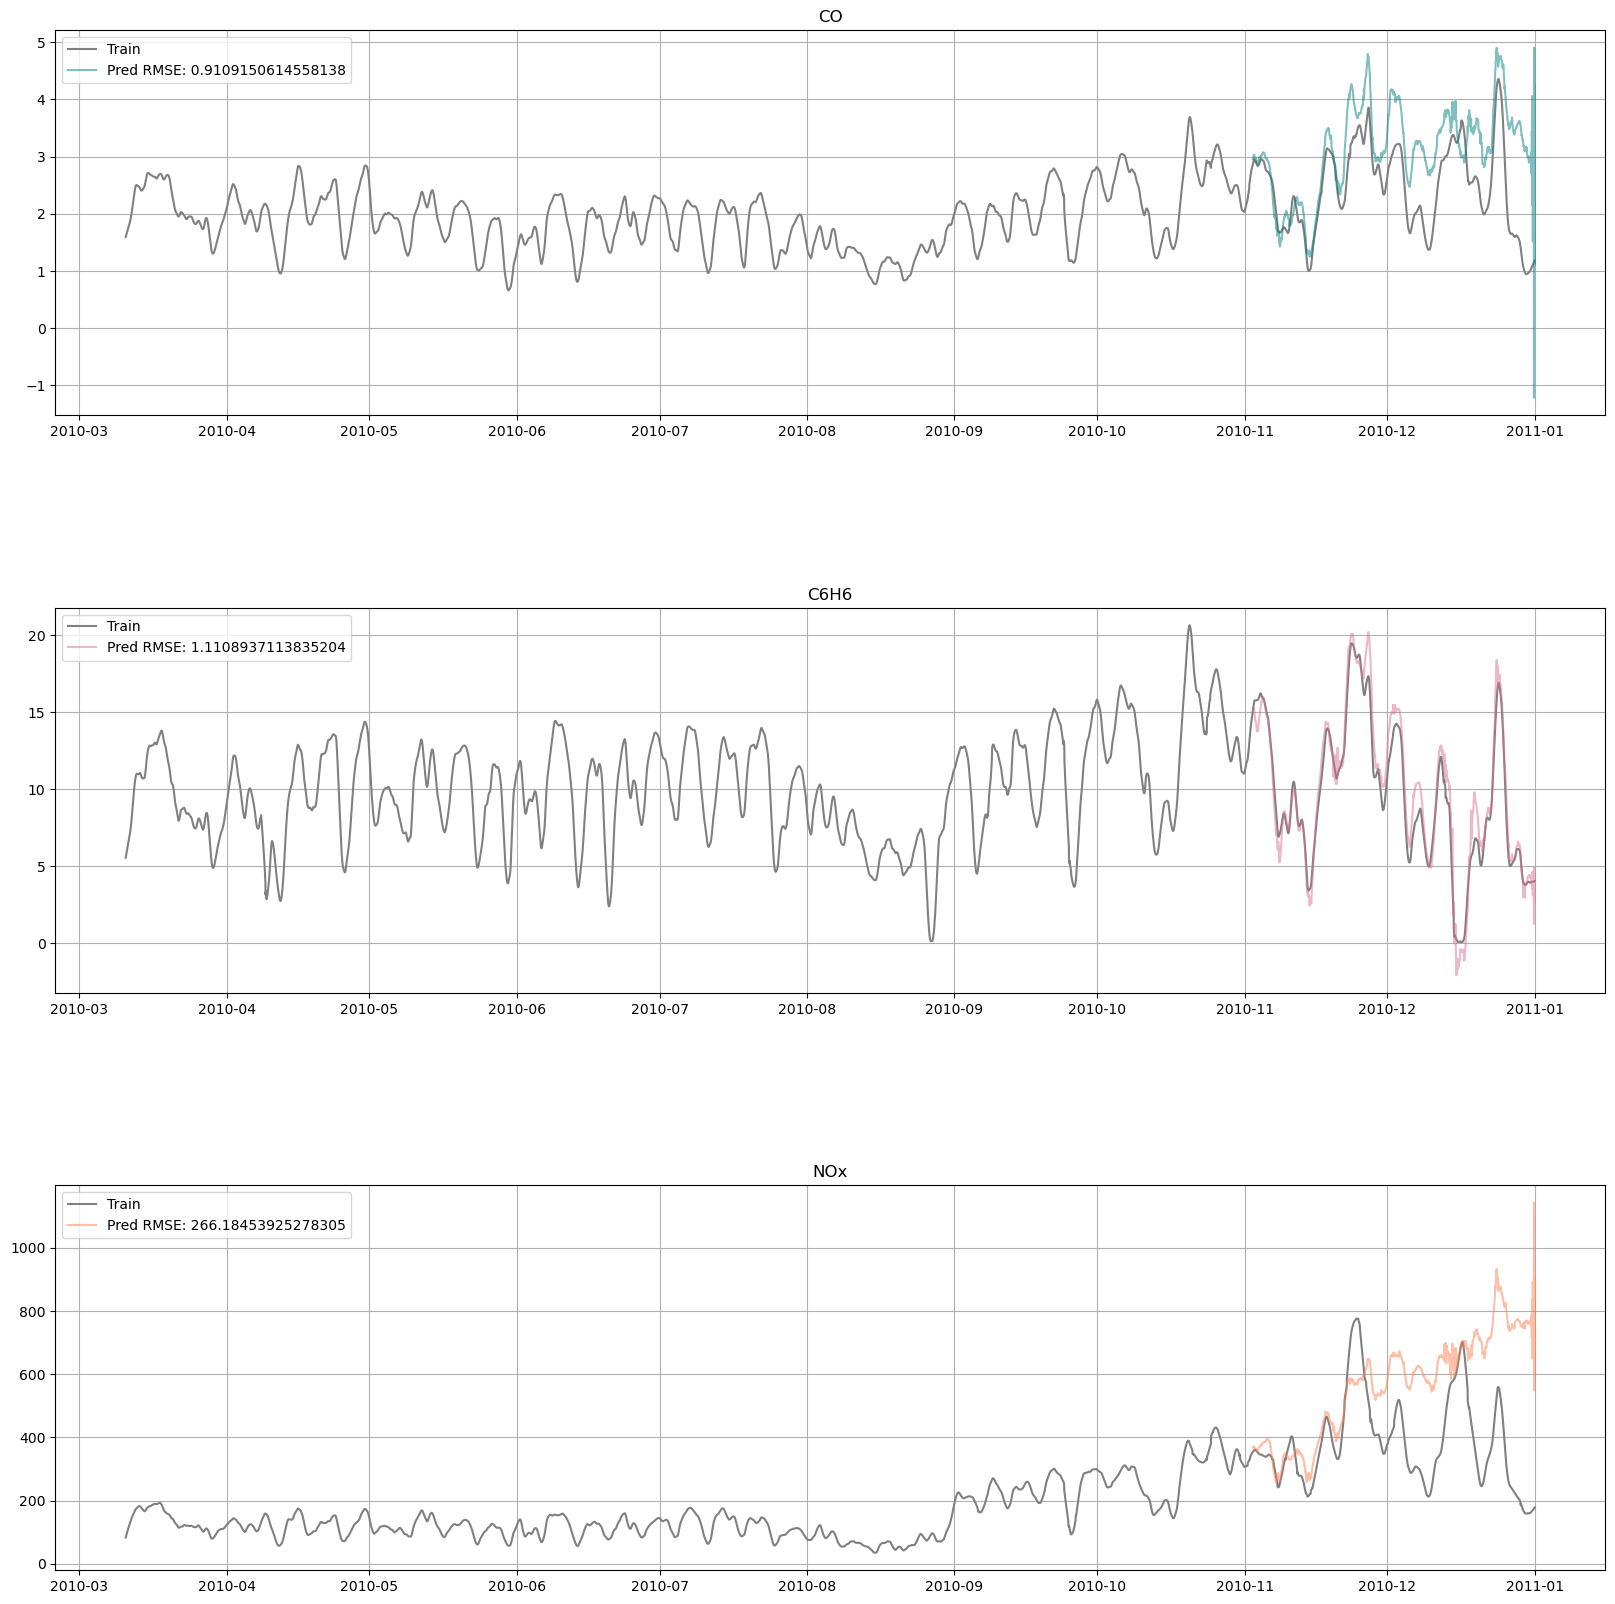

In [117]:
colors = ['teal', 'palevioletred', 'coral']
target_names = ['CO', 'C6H6', 'NOx']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'rmse_{target_names[i]}'
    name2 = f'df_trend_{target_names[i]}_val'
    name3 = f'pred_val_{target_names[i]}'

    axs[i].plot(df_trend['date_time'], df_trend[targets[i]], color='gray', label='Train')
    axs[i].plot(globals()[name2]['ds'], globals()[name3].iloc[:, -1], color=colors[i], alpha=0.5, label=f'Pred RMSE: {globals()[name1]}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

##### optunaでパラメ最適化してみよう

In [118]:
df_trend_CO_train['cap'] = int(np.max(df_trend_CO_train.y))
df_trend_CO_train['floor'] = int(np.min(df_trend_CO_train.y))
df_trend_CO_val['cap'] = int(np.max(df_trend_CO_train.y))
df_trend_CO_val['floor'] = int(np.min(df_trend_CO_train.y))

df_trend_C6H6_train['cap'] = int(np.max(df_trend_C6H6_train.y))
df_trend_C6H6_train['floor'] = int(np.min(df_trend_C6H6_train.y))
df_trend_C6H6_val['cap'] = int(np.max(df_trend_C6H6_train.y))
df_trend_C6H6_val['floor'] = int(np.min(df_trend_C6H6_train.y))

df_trend_NOx_train['cap'] = int(np.max(df_trend_NOx_train.y))
df_trend_NOx_train['floor'] = int(np.min(df_trend_NOx_train.y))
df_trend_NOx_val['cap'] = int(np.max(df_trend_NOx_train.y))
df_trend_NOx_val['floor'] = int(np.min(df_trend_NOx_train.y))

In [119]:
def objective_variable(train,valid):

    cap = int(np.max(train.y))
    floor = int(np.min(train.y))

    def objective(trial):
            params = {
                    'changepoint_range' : trial.suggest_discrete_uniform('changepoint_range',0.8,0.95,0.001),
                    'n_changepoints' : trial.suggest_int('n_changepoints',20,35),
                    'changepoint_prior_scale' : trial.suggest_discrete_uniform('changepoint_prior_scale',0.001,0.5,0.001),
                    'seasonality_prior_scale' : trial.suggest_discrete_uniform('seasonality_prior_scale',1,25,0.5),
                     }
            # fit_model
            model = Prophet(
                    changepoint_range = params['changepoint_prior_scale'],
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')
            
            for i in range(len(features)):
                 model.add_regressor(features[i])

            train['cap'] = cap
            train['floor'] = floor

            model.fit(train)

            valid['cap'] = cap
            valid['floor'] = floor           

            forecast = model.predict(valid)

            val_rmse = rmse(valid.y, forecast.yhat)
            return val_rmse

    return objective


def get_parameter(train,valid):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123), direction='minimize')
    study.optimize(objective_variable(train,valid), timeout=60)

    return study

In [120]:
study_CO = get_parameter(df_trend_CO_train, df_trend_CO_val)

14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:52:02 - cmdstanpy - INFO - Chain [1] done processing
14:52:10 - cmdstanpy - INFO - Chain [1] start processing
14:52:21 - cmdstanpy - INFO - Chain [1] done processing
14:52:29 - cmdstanpy - INFO - Chain [1] start processing
14:52:41 - cmdstanpy - INFO - Chain [1] done processing
14:52:48 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing


In [121]:
study_C6H6 = get_parameter(df_trend_C6H6_train, df_trend_C6H6_val)

14:53:07 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:26 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:45 - cmdstanpy - INFO - Chain [1] start processing
14:53:56 - cmdstanpy - INFO - Chain [1] done processing
14:54:04 - cmdstanpy - INFO - Chain [1] start processing
14:54:14 - cmdstanpy - INFO - Chain [1] done processing


In [122]:
study_NOx = get_parameter(df_trend_NOx_train, df_trend_NOx_val)

14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing
14:54:40 - cmdstanpy - INFO - Chain [1] start processing
14:54:51 - cmdstanpy - INFO - Chain [1] done processing
14:54:59 - cmdstanpy - INFO - Chain [1] start processing
14:55:10 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:28 - cmdstanpy - INFO - Chain [1] done processing


In [123]:
model_CO_2 = Prophet(changepoint_range = study_CO.best_params['changepoint_prior_scale'],
                    n_changepoints = study_CO.best_params['n_changepoints'],
                    changepoint_prior_scale = study_CO.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_CO.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_CO_2.add_regressor(features[i])

df_trend_CO_train['cap'] = int(np.max(df_trend_CO_train.y))
df_trend_CO_train['floor'] = int(np.min(df_trend_CO_train.y))

model_CO_2.fit(df_trend_CO_train)

df_trend_CO_val['cap'] = int(np.max(df_trend_CO_train.y))
df_trend_CO_val['floor'] = int(np.min(df_trend_CO_train.y))

pred_val_CO_2 = model_CO_2.predict(df_trend_CO_val)

14:55:36 - cmdstanpy - INFO - Chain [1] start processing
14:55:47 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
model_C6H6_2 = Prophet(changepoint_range = study_C6H6.best_params['changepoint_prior_scale'],
                    n_changepoints = study_C6H6.best_params['n_changepoints'],
                    changepoint_prior_scale = study_C6H6.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_C6H6.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_C6H6_2.add_regressor(features[i])

df_trend_C6H6_train['cap'] = int(np.max(df_trend_C6H6_train.y))
df_trend_C6H6_train['floor'] = int(np.min(df_trend_C6H6_train.y))

model_C6H6_2.fit(df_trend_C6H6_train)

df_trend_C6H6_val['cap'] = int(np.max(df_trend_C6H6_train.y))
df_trend_C6H6_val['floor'] = int(np.min(df_trend_C6H6_train.y))

pred_val_C6H6_2 = model_C6H6_2.predict(df_trend_C6H6_val)

14:55:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:05 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
model_NOx_2 = Prophet(changepoint_range = study_NOx.best_params['changepoint_prior_scale'],
                    n_changepoints = study_NOx.best_params['n_changepoints'],
                    changepoint_prior_scale = study_NOx.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_NOx.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_NOx_2.add_regressor(features[i])

df_trend_NOx_train['cap'] = int(np.max(df_trend_NOx_train.y))
df_trend_NOx_train['floor'] = int(np.min(df_trend_NOx_train.y))

model_NOx_2.fit(df_trend_NOx_train)

df_trend_NOx_val['cap'] = int(np.max(df_trend_NOx_train.y))
df_trend_NOx_val['floor'] = int(np.min(df_trend_NOx_train.y))

pred_val_NOx_2 = model_NOx_2.predict(df_trend_NOx_val)

14:56:14 - cmdstanpy - INFO - Chain [1] start processing
14:56:26 - cmdstanpy - INFO - Chain [1] done processing


結果：

In [126]:
rmse_CO_2 = rmse(df_trend_CO_val.y, pred_val_CO.yhat)
rmse_C6H6_2 = rmse(df_trend_C6H6_val.y, pred_val_C6H6.yhat)
rmse_NOx_2 = rmse(df_trend_NOx_val.y, pred_val_NOx.yhat)

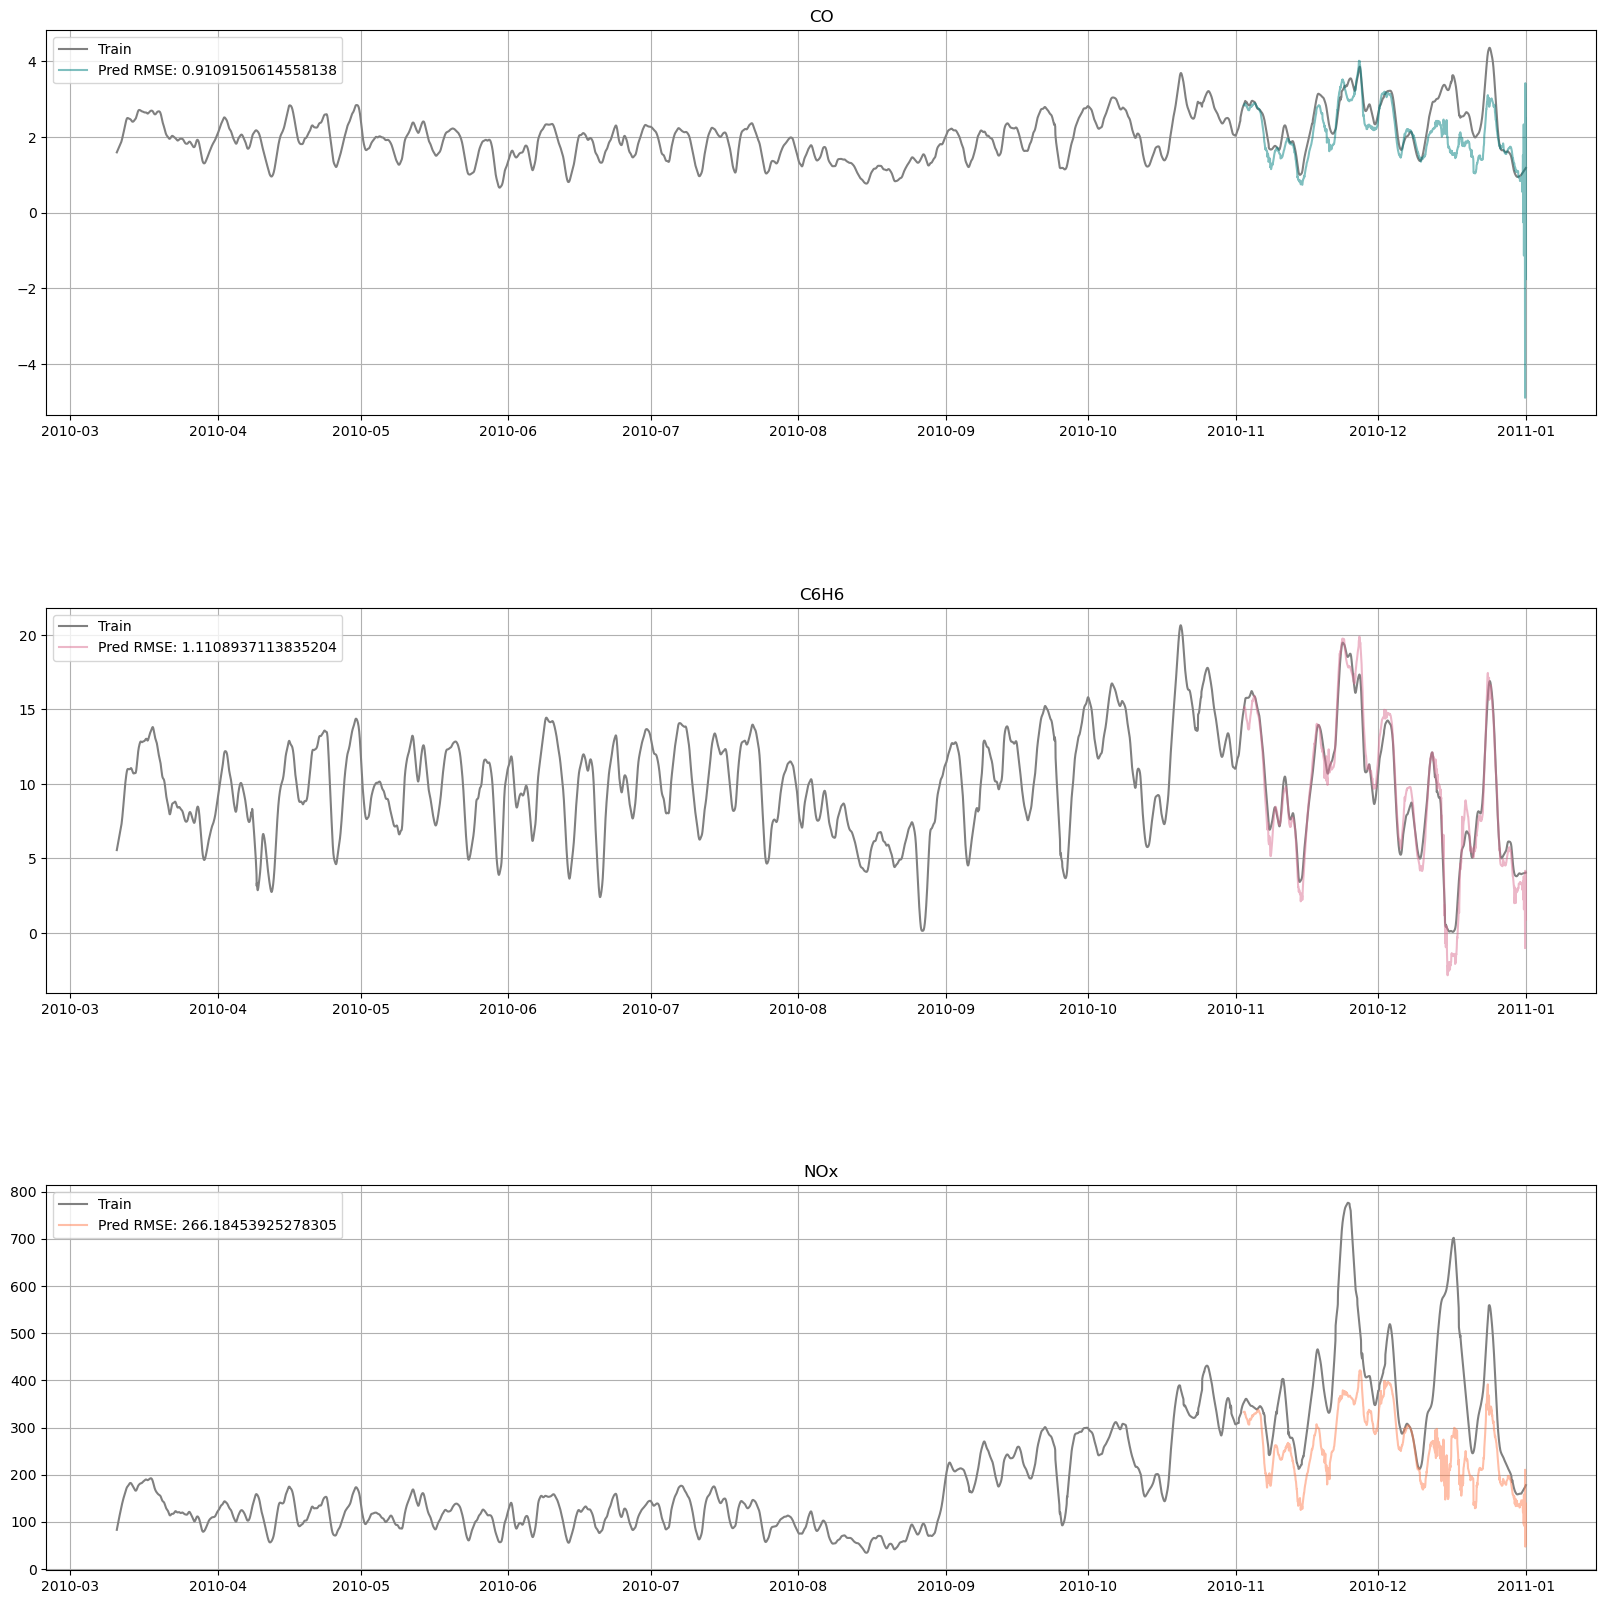

In [127]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'rmse_{target_names[i]}_2'
    name2 = f'df_trend_{target_names[i]}_val'
    name3 = f'pred_val_{target_names[i]}_2'

    axs[i].plot(df_trend['date_time'], df_trend[targets[i]], color='gray', label='Train')
    axs[i].plot(globals()[name2]['ds'], globals()[name3].iloc[:, -1], color=colors[i], alpha=0.5, label=f'Pred RMSE: {globals()[name1]}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

### トレンド成分をlightGBMで予測してみる

In [128]:
categorical_features = ['day_of_week', 'working_hours']

df_trend_CO_train.set_index('ds', inplace=True)
df_trend_CO_val.set_index('ds', inplace=True)
train_y_CO = df_trend_CO_train['y']
train_x_CO = df_trend_CO_train.drop('y', axis=1)
val_y_CO = df_trend_CO_val['y']
val_x_CO = df_trend_CO_val.drop('y', axis=1)

df_trend_C6H6_train.set_index('ds', inplace=True)
df_trend_C6H6_val.set_index('ds', inplace=True)
train_y_C6H6 = df_trend_C6H6_train['y']
train_x_C6H6 = df_trend_C6H6_train.drop('y', axis=1)
val_y_C6H6 = df_trend_C6H6_val['y']
val_x_C6H6 = df_trend_C6H6_val.drop('y', axis=1)

df_trend_NOx_train.set_index('ds', inplace=True)
df_trend_NOx_val.set_index('ds', inplace=True)
train_y_NOx = df_trend_NOx_train['y']
train_x_NOx = df_trend_NOx_train.drop('y', axis=1)
val_y_NOx = df_trend_NOx_val['y']
val_x_NOx = df_trend_NOx_val.drop('y', axis=1)

##### まずは対数変換なしで

In [129]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_CO, train_y_CO)
    lgb_valids = lgb.Dataset(val_x_CO, val_y_CO)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_CO = regressor.predict(val_x_CO)

    val_rmse = rmse(val_y_CO, lgb_pred_val_y_CO)
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=300)

In [130]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(train_x_CO, train_y_CO)
valids = lgb.Dataset(val_x_CO, val_y_CO)

model_lgb_CO = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_CO = model_lgb_CO.predict(val_x_CO)
rmse_CO = rmse(val_y_CO, val_lgb_CO)

#lgb_pred_CO = model_lgb_CO.predict(df_test)

rmse_CO

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32392
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 1.897814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped

0.5249538612482005

In [131]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
    lgb_valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_C6H6 = regressor.predict(val_x_C6H6)

    val_rmse = rmse(val_y_C6H6, lgb_pred_val_y_C6H6)
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=300)

In [132]:
# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)

model_lgb_C6H6 = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_C6H6 = model_lgb_C6H6.predict(val_x_C6H6)
rmse_C6H6 = rmse(val_y_C6H6, val_lgb_C6H6)

#lgb_pred_CO = model_lgb_CO.predict(df_test)

rmse_C6H6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32392
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 9.983101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.764347902700014

In [133]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_NOx, train_y_NOx)
    lgb_valids = lgb.Dataset(val_x_NOx, val_y_NOx)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_NOx = regressor.predict(val_x_NOx)

    val_rmse = rmse(val_y_NOx, lgb_pred_val_y_NOx)
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=300)

In [134]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(train_x_NOx, train_y_NOx)
valids = lgb.Dataset(val_x_NOx, val_y_NOx)

model_lgb_NOx = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_NOx = model_lgb_NOx.predict(val_x_NOx)
rmse_NOx = rmse(val_y_NOx, val_lgb_NOx)

#lgb_pred_CO = model_lgb_CO.predict(df_test)

rmse_NOx

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32392
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 150.983803


204.8038973275265

結果：NOxだけはProphetの結果の方が良い

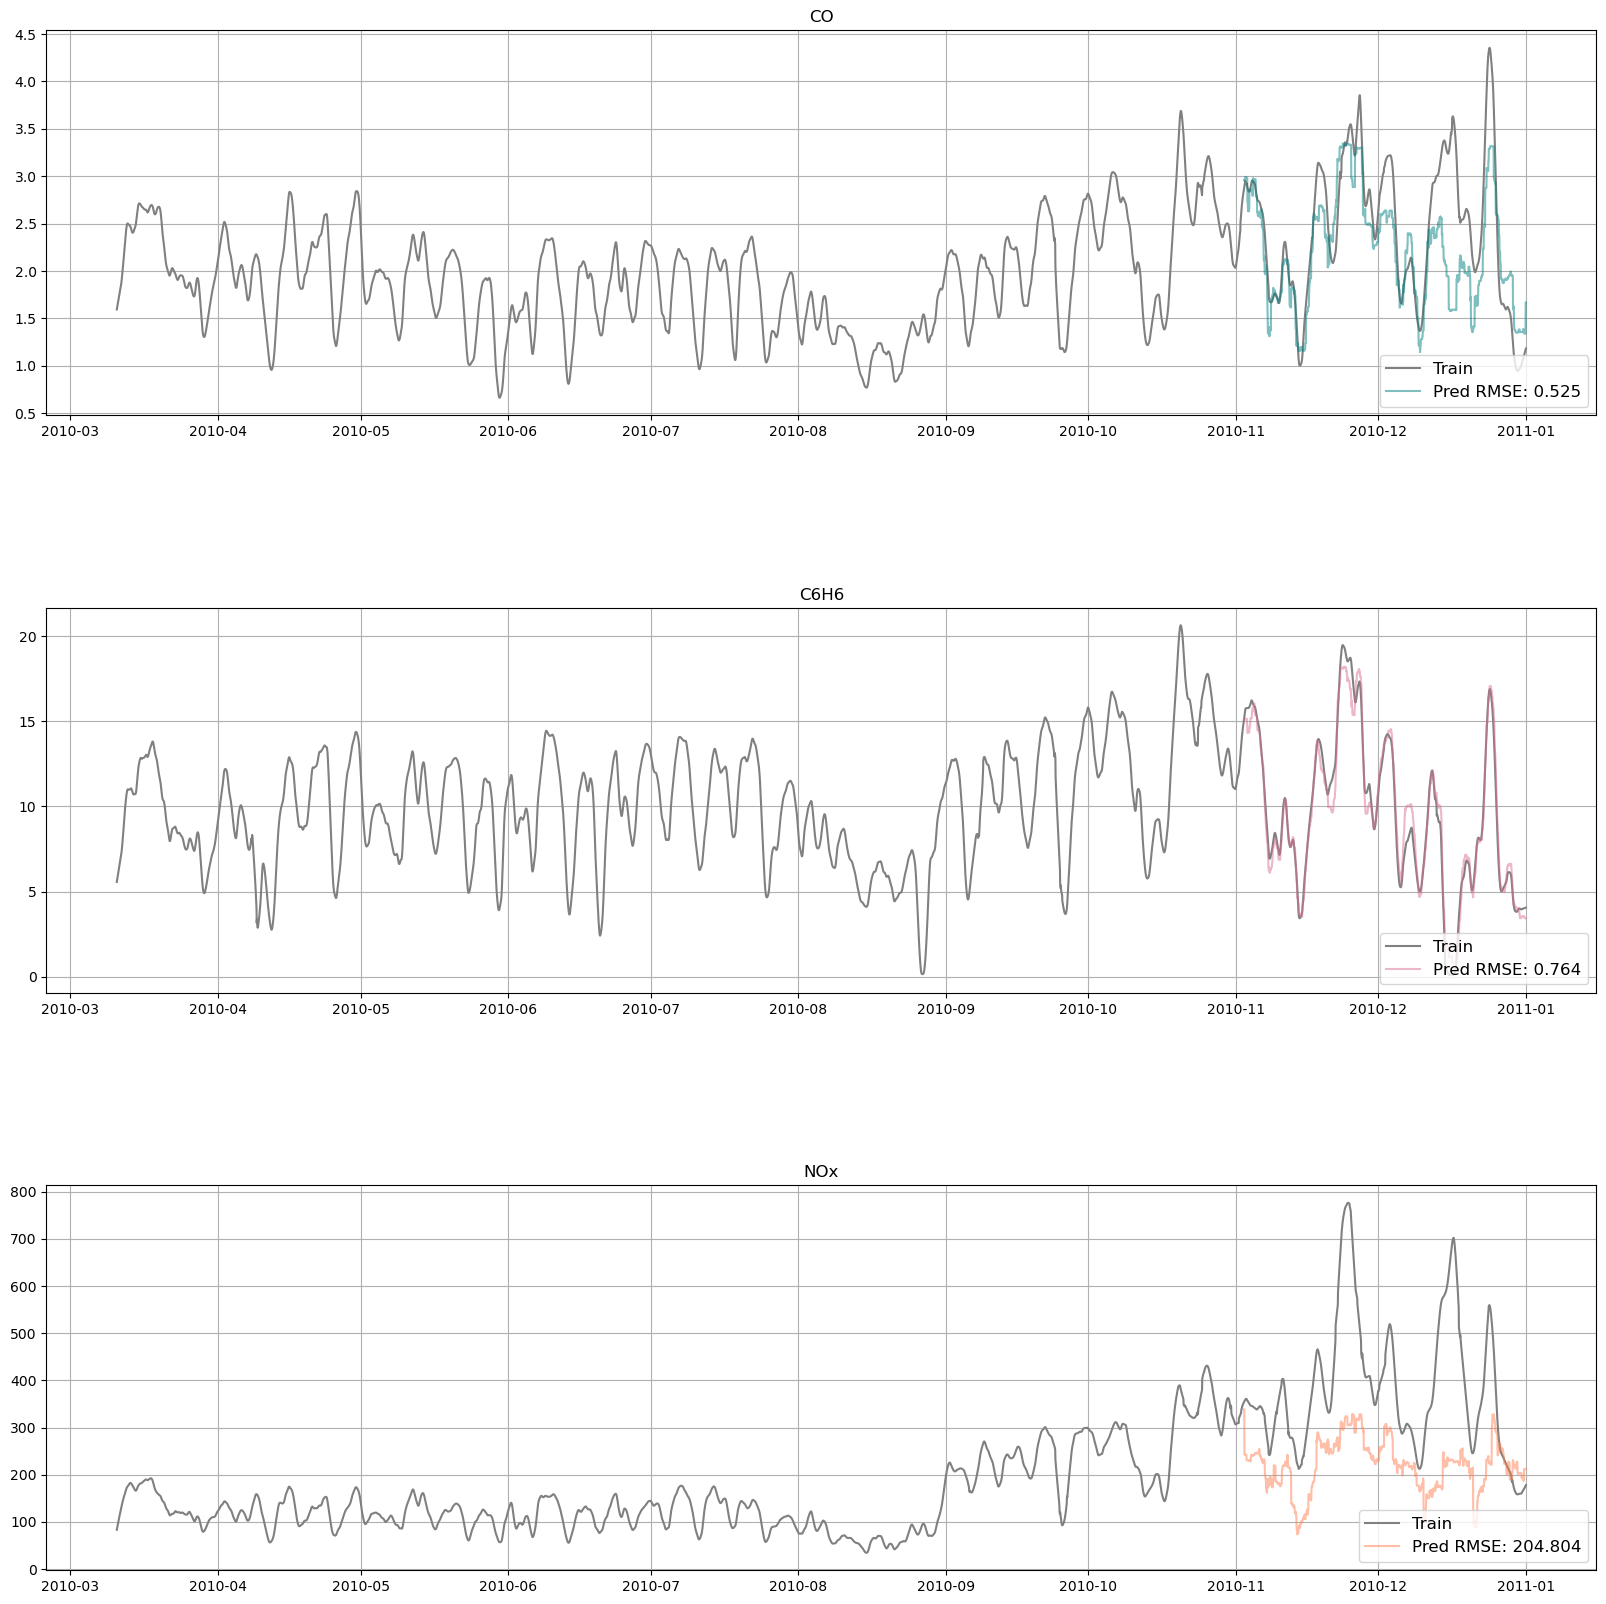

In [135]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)


for i in range(3):

    name1 = f'val_lgb_{target_names[i]}'
    name2 = f'rmse_{target_names[i]}'  

    axs[i].plot(df_trend['date_time'], df_trend[targets[i]], color='gray', label='Train')
    axs[i].plot(val_x_CO.index, globals()[name1], color=colors[i], alpha=0.5, label=f'Pred RMSE: {globals()[name2]:.3f}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend(loc='lower right', fontsize=12)

plt.show()

##### 対数変換するとどうなるか

In [136]:
train_y_CO = np.log1p(df_trend_CO_train['y'])
val_y_CO = np.log1p(df_trend_CO_val['y'])

train_y_C6H6 = np.log1p(df_trend_C6H6_train['y'])
val_y_C6H6 = np.log1p(df_trend_C6H6_val['y'])

train_y_NOx = np.log1p(df_trend_NOx_train['y'])
val_y_NOx = np.log1p(df_trend_NOx_val['y'])

In [137]:

# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_CO, train_y_CO)
    lgb_valids = lgb.Dataset(val_x_CO, val_y_CO)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_CO = regressor.predict(val_x_CO)

    val_rmse = rmse(np.expm1(val_y_CO), np.expm1(lgb_pred_val_y_CO))
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=600)

In [138]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(train_x_CO, train_y_CO)
valids = lgb.Dataset(val_x_CO, val_y_CO)

model_lgb_CO_2 = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_CO_2 = model_lgb_CO_2.predict(val_x_CO)
rmse_CO_2 = rmse(np.expm1(val_y_CO), np.expm1(val_lgb_CO_2))

#lgb_pred_CO = np.expm1(model_lgb_CO.predict(df_test))

rmse_CO_2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32392
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 1.046742


0.4707608000582001

In [139]:

# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
    lgb_valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_C6H6 = regressor.predict(val_x_C6H6)

    val_rmse = rmse(np.expm1(val_y_C6H6), np.expm1(lgb_pred_val_y_C6H6))
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=600)

In [140]:
# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)

model_lgb_C6H6_2 = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_C6H6_2 = model_lgb_C6H6_2.predict(val_x_C6H6)
rmse_C6H6_2 = rmse(np.expm1(val_y_C6H6), np.expm1(val_lgb_C6H6_2))

#lgb_pred_C6H6 = np.expm1(model_lgb_C6H6.predict(df_test))

rmse_C6H6_2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32392
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 2.342350
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

0.7673197286143151

In [141]:

# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_NOx, train_y_NOx)
    lgb_valids = lgb.Dataset(val_x_NOx, val_y_NOx)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_NOx = regressor.predict(val_x_NOx)

    val_rmse = rmse(np.expm1(val_y_NOx), np.expm1(lgb_pred_val_y_NOx))
    
    return val_rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=600)

In [142]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(train_x_NOx, train_y_NOx)
valids = lgb.Dataset(val_x_NOx, val_y_NOx)

model_lgb_NOx_2 = lgb.train(study.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_NOx_2 = model_lgb_NOx_2.predict(val_x_NOx)
rmse_NOx_2 = rmse(np.expm1(val_y_NOx), np.expm1(val_lgb_NOx_2))

#lgb_pred_NOx = np.expm1(model_lgb_NOx.predict(df_test))

rmse_NOx_2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32392
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 128
[LightGBM] [Info] Start training from score 4.902222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


205.2499898245488

結果：大して変わらず

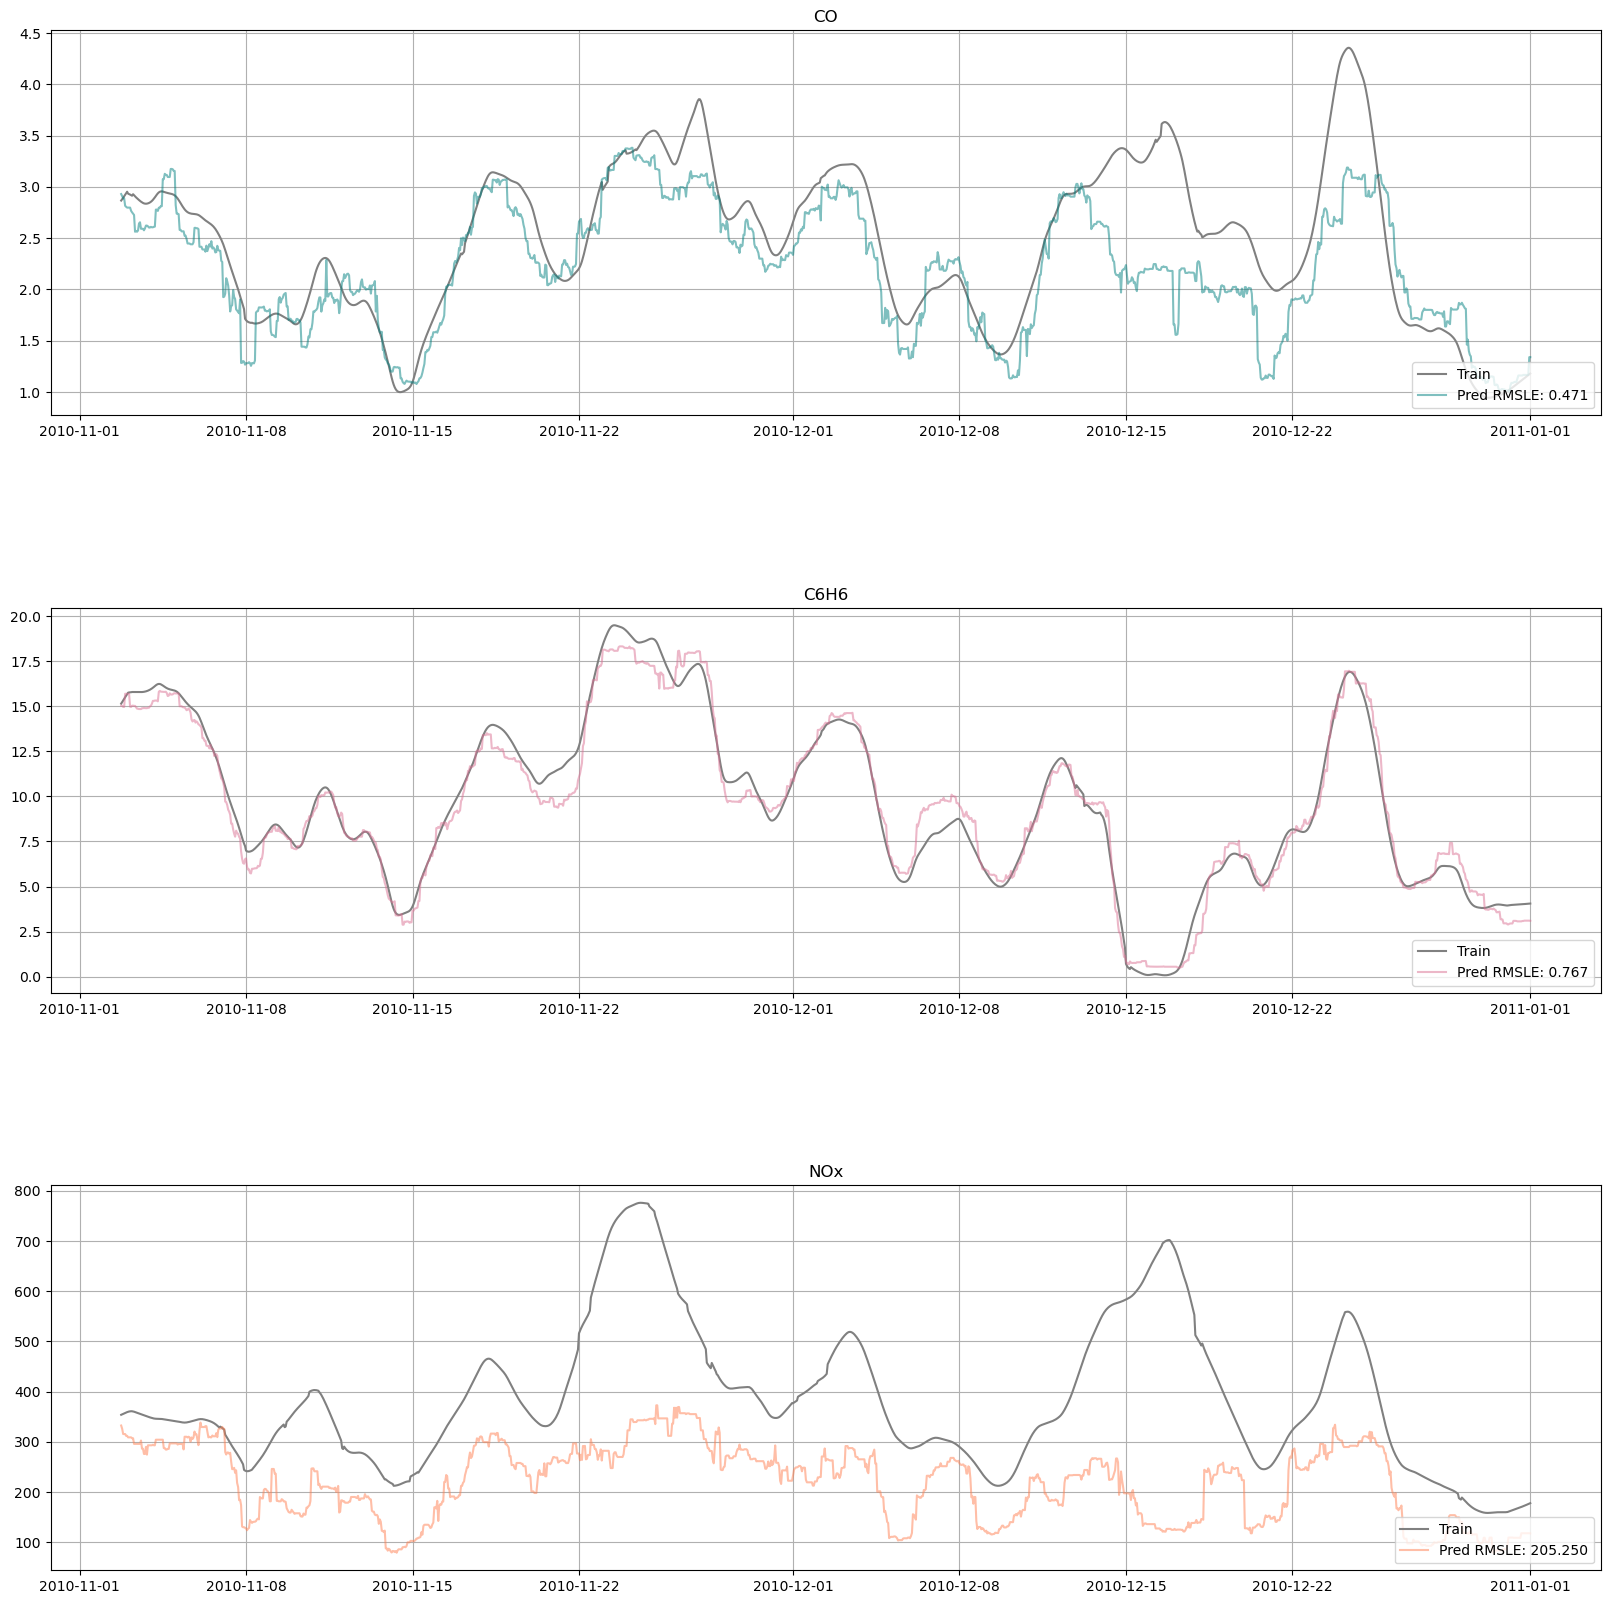

In [143]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)


for i in range(3):

    name1 = f'val_lgb_{target_names[i]}_2'
    name2 = f'rmse_{target_names[i]}_2'
    name3 = f'val_y_{target_names[i]}'

    axs[i].plot(val_x_CO.index, np.expm1(globals()[name3]), color='gray', label='Train')
    axs[i].plot(val_x_CO.index, np.expm1(globals()[name1]), color=colors[i], alpha=0.5, label=f'Pred RMSLE: {globals()[name2]:.3f}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend(loc='lower right')

plt.show()

### トレンド予測の結論：

COとC6H6は時系列特徴量あり目的変数対数変換なしlightGBM<br>
NOxはProphetで行きます

### NOxの目的変数を対数変換してProphetで予測

In [144]:
df_trend_NOx_train.y = np.log1p(df_trend_NOx_train.y)
df_trend_NOx_val.y = np.log1p(df_trend_NOx_val.y)

#df_trend_NOx_train['cap'] = int(np.max(df_trend_NOx_train.y))
#df_trend_NOx_train['floor'] = int(np.min(df_trend_NOx_train.y))
#df_trend_NOx_val['cap'] = int(np.max(df_trend_NOx_train.y))
#df_trend_NOx_val['floor'] = int(np.min(df_trend_NOx_train.y))

In [145]:
def objective_variable(train,valid):

    cap = int(np.max(train.y))
    floor = int(np.min(train.y))

    def objective(trial):
            params = {
                    'changepoint_range' : trial.suggest_discrete_uniform('changepoint_range',0.8,0.95,0.001),
                    'n_changepoints' : trial.suggest_int('n_changepoints',20,35),
                    'changepoint_prior_scale' : trial.suggest_discrete_uniform('changepoint_prior_scale',0.001,0.5,0.001),
                    'seasonality_prior_scale' : trial.suggest_discrete_uniform('seasonality_prior_scale',1,25,0.5),
                     }
            # fit_model
            model = Prophet(
                    changepoint_range = params['changepoint_prior_scale'],
                    n_changepoints=params['n_changepoints'],
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale = params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')
            
            for i in range(len(features)):
                 model.add_regressor(features[i])

            train['cap'] = cap
            train['floor'] = floor

            model.fit(train)

            valid['cap'] = cap
            valid['floor'] = floor           

            forecast = model.predict(valid)

            val_rmse = rmse(np.expm1(valid.y), np.expm1(forecast.yhat))
            return val_rmse

    return objective


def get_parameter(train,valid):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123), direction='minimize')
    study.optimize(objective_variable(train,valid), timeout=60)

    return study

In [146]:
df_trend_NOx_train = df_trend_NOx_train.reset_index()
df_trend_NOx_val = df_trend_NOx_val.reset_index()

study_NOx_log = get_parameter(df_trend_NOx_train, df_trend_NOx_val)

15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:43 - cmdstanpy - INFO - Chain [1] done processing
15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:02 - cmdstanpy - INFO - Chain [1] done processing
15:42:09 - cmdstanpy - INFO - Chain [1] start processing
15:42:20 - cmdstanpy - INFO - Chain [1] done processing
15:42:28 - cmdstanpy - INFO - Chain [1] start processing
15:42:38 - cmdstanpy - INFO - Chain [1] done processing


In [147]:
model_NOx_log = Prophet(changepoint_range = study_NOx_log.best_params['changepoint_prior_scale'],
                    n_changepoints = study_NOx_log.best_params['n_changepoints'],
                    changepoint_prior_scale = study_NOx_log.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_NOx_log.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_NOx_log.add_regressor(features[i])

df_trend_NOx_train['cap'] = int(np.max(df_trend_NOx_train.y))
df_trend_NOx_train['floor'] = int(np.min(df_trend_NOx_train.y))

model_NOx_log.fit(df_trend_NOx_train)

df_trend_NOx_val['cap'] = int(np.max(df_trend_NOx_train.y))
df_trend_NOx_val['floor'] = int(np.min(df_trend_NOx_train.y))

pred_val_NOx_log = model_NOx_log.predict(df_trend_NOx_val)

15:42:46 - cmdstanpy - INFO - Chain [1] start processing
15:42:52 - cmdstanpy - INFO - Chain [1] done processing


##### 結果：良くはないけどだいぶマシになった

In [148]:
rmse_NOx_log = rmse(df_trend_NOx_val.y, pred_val_NOx_log.yhat)

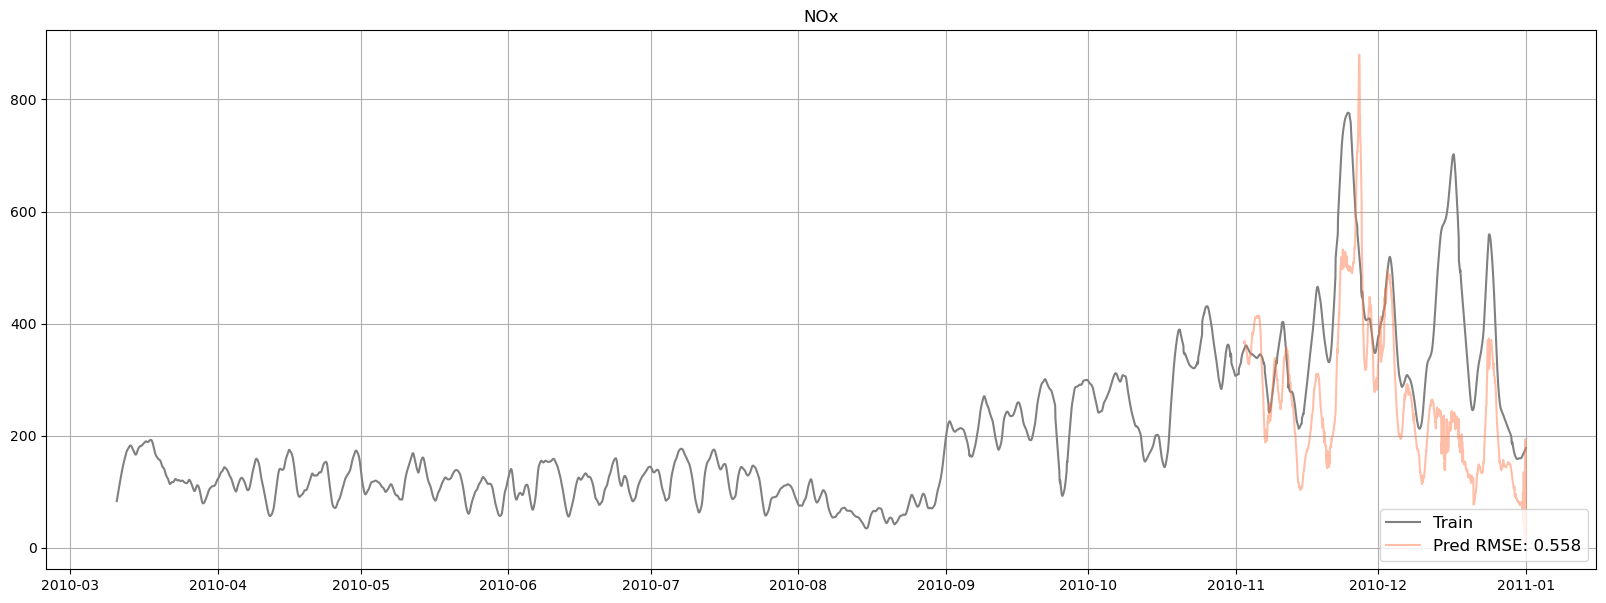

In [149]:
fig, axs = plt.subplots(figsize=(20, 7), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

axs.plot(df_trend['date_time'], df_trend[targets[2]], color='gray', label='Train')
axs.plot(df_trend_NOx_val['ds'], np.expm1(pred_val_NOx_log.yhat), color=colors[2], alpha=0.5, label=f'Pred RMSE: {rmse_NOx_log:.3f}')
axs.set_title(f'{target_names[2]}')
axs.grid(axis='both')
axs.legend(loc='lower right', fontsize=12)

plt.show()

##### NeuralProphetでもやってみる

In [150]:
# Optunaでパラメータ探索
def objective_variable(train,valid):

    cap = int(np.max(train.y))
    floor = int(np.min(train.y))

    def objective(trial):
            params = {
                    'changepoints_range' : trial.suggest_discrete_uniform('changepoints_range',0.8,0.95,0.01),
                    'n_changepoints' : trial.suggest_int('n_changepoints',20,35),
                    'trend_reg' : trial.suggest_discrete_uniform('trend_reg',0,2,0.01),
                    'seasonality_reg' : trial.suggest_discrete_uniform('seasonality_reg',0,1,0.2),
                    'seasonality_mode'  : trial.suggest_categorical('seasonality_mode',['additive','multiplicative'])
                     }
            # fit_model
            model = NeuralProphet(
                    changepoints_range = params['changepoints_range'],
                    n_changepoints=params['n_changepoints'],
                    trend_reg = params['trend_reg'],
                    yearly_seasonality = False,
                    weekly_seasonality = True,
                    daily_seasonality = True,
                    seasonality_reg = params['seasonality_reg'],
                    epochs = None,
                    batch_size = None,
                    seasonality_mode=params['seasonality_mode'])
            
            for i in range(len(features)):
                 model.add_future_regressor(features[i])

            #train['cap'] = cap
            #train['floor'] = floor

            model.fit(train)

            #valid['cap'] = cap
            #valid['floor'] = floor           

            forecast = model.predict(valid)

            val_rmse = rmse(np.expm1(valid.y), np.expm1(forecast.yhat1))
            return val_rmse

    return objective


def get_parameter(train,valid):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=123), direction='minimize')
    study.optimize(objective_variable(train,valid), timeout=60)

    return study

In [151]:
df_trend_NOx_train = df_trend_NOx_train.drop(['cap', 'floor'], axis=1)
df_trend_NOx_val = df_trend_NOx_val.drop(['cap', 'floor'], axis=1)

In [152]:
study_NOx_log_neuralProphet = get_parameter(df_trend_NOx_train, df_trend_NOx_val)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 119
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (178) is too small than the required number for the learning rate finder (244). The results might not be optimal.


Finding best initial lr:   0%|          | 0/244 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 178it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 119
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (178) is too small than the required number for the learning rate finder (244). The results mi

Finding best initial lr:   0%|          | 0/244 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 178it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 119
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (178) is too small than the required number for the learning rate finder (244). The results mi

Finding best initial lr:   0%|          | 0/244 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 178it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [153]:
model_NOx_log_neuralprophet = NeuralProphet(
                                changepoints_range = study_NOx_log_neuralProphet.best_params['changepoints_range'],
                                n_changepoints = study_NOx_log_neuralProphet.best_params['n_changepoints'],
                                trend_reg = study_NOx_log_neuralProphet.best_params['trend_reg'],
                                yearly_seasonality = False,
                                weekly_seasonality = True,
                                daily_seasonality = True,
                                seasonality_reg = study_NOx_log_neuralProphet.best_params['seasonality_reg'],
                                epochs = None,
                                batch_size =  None,
                                seasonality_mode = study_NOx_log_neuralProphet.best_params['seasonality_mode'])

for i in range(len(features)):
    model_NOx_log_neuralprophet.add_future_regressor(features[i])


model_NOx_log_neuralprophet.fit(df_trend_NOx_train)


pred_val_NOx_log_neuralprophet = model_NOx_log_neuralprophet.predict(df_trend_NOx_val)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 119
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (178) is too small than the required number for the learning rate finder (244). The results might not be optimal.


Finding best initial lr:   0%|          | 0/244 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.93% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 178it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [154]:
rmse_NOx_log_neuralprophet = rmse(np.expm1(df_trend_NOx_val.y), np.expm1(pred_val_NOx_log_neuralprophet.yhat1))

結果：ダメですね

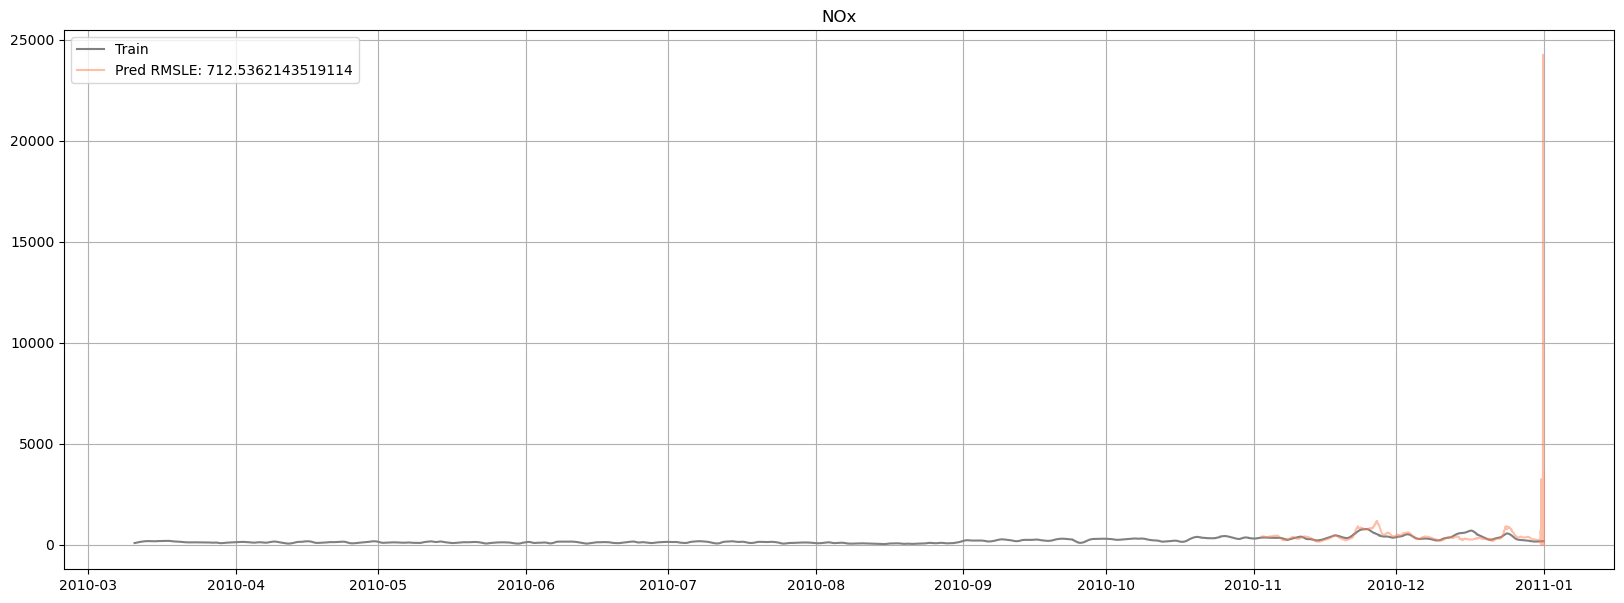

In [155]:
fig, axs = plt.subplots(figsize=(20, 7), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

axs.plot(df_trend['date_time'], df_trend[targets[2]], color='gray', label='Train')
axs.plot(df_trend_NOx_val['ds'], np.expm1(pred_val_NOx_log_neuralprophet.yhat1), color=colors[2], alpha=0.5, label=f'Pred RMSLE: {rmse_NOx_log_neuralprophet}')
axs.set_title(f'{target_names[2]}')
axs.grid(axis='both')
axs.legend()

plt.show()

### 最終結果を得る

In [156]:
df_test = df_test.rename(columns={'date_time': 'ds'})
df_test = features_stl(df_test)

100%|██████████| 129/129 [00:19<00:00,  6.72it/s]


##### lightGBMでCOとC6H6のテストデータ範囲を予測

In [157]:
df_test_lgbm = df_test.copy()
df_test_lgbm.set_index('ds', inplace=True)

In [158]:
pred_CO = np.expm1(model_lgb_CO_2.predict(df_test_lgbm, predict_disable_shape_check=True))

In [159]:
pred_C6H6 = np.expm1(model_lgb_C6H6_2.predict(df_test_lgbm, predict_disable_shape_check=True))

##### 目的変数を対数変換しProphetでTrainデータをすべて学習させてNOxのテストデータ範囲を予想

In [160]:
df_trend_NOx.y = np.log1p(df_trend_NOx.y)

In [161]:
model_NOx_log = Prophet(changepoint_range = study_NOx_log.best_params['changepoint_prior_scale'],
                    n_changepoints = study_NOx_log.best_params['n_changepoints'],
                    changepoint_prior_scale = study_NOx_log.best_params['changepoint_prior_scale'],
                    seasonality_prior_scale = study_NOx_log.best_params['seasonality_prior_scale'],
                    yearly_seasonality=False,
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    growth='logistic',
                    seasonality_mode='additive')

for i in range(len(features)):
    model_NOx_log.add_regressor(features[i])

df_trend_NOx['cap'] = int(np.max(df_trend_NOx.y))
df_trend_NOx['floor'] = int(np.min(df_trend_NOx.y))

model_NOx_log.fit(df_trend_NOx)

df_test['cap'] = int(np.max(df_trend_NOx.y))
df_test['floor'] = int(np.min(df_trend_NOx.y))

pred_NOx_log = model_NOx_log.predict(df_test)

pred_NOx = np.expm1(pred_NOx_log.yhat)

15:45:14 - cmdstanpy - INFO - Chain [1] start processing
15:45:22 - cmdstanpy - INFO - Chain [1] done processing


In [162]:
df_val = pd.DataFrame(columns=['CO', 'C6H6', 'NOx'])

df_val['CO'] = np.expm1(val_lgb_CO_2)
df_val['C6H6'] = np.expm1(val_lgb_C6H6_2)
df_val['NOx'] = np.expm1(val_lgb_NOx_2)

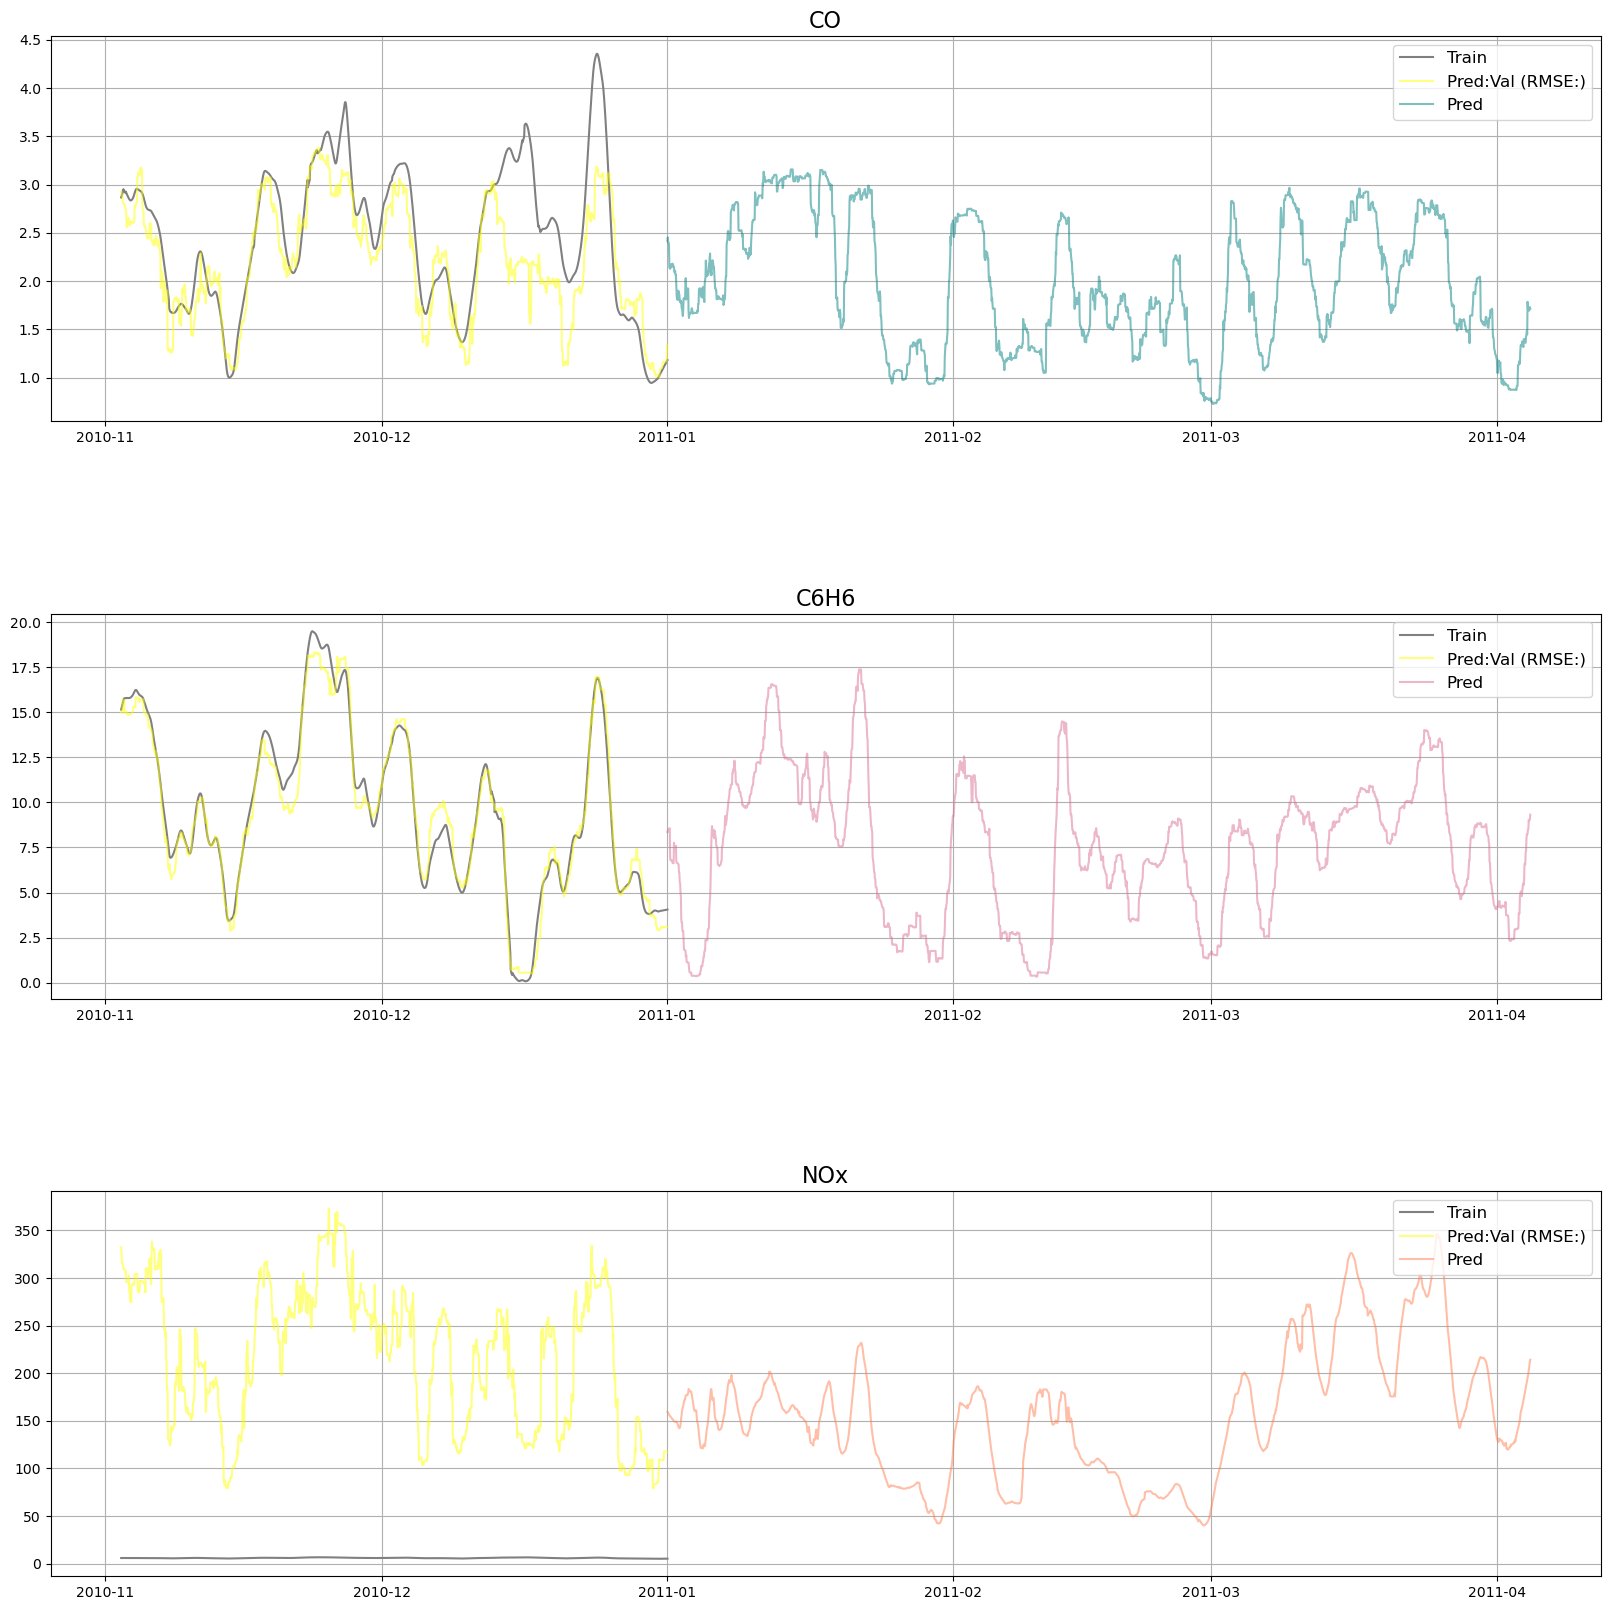

In [163]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    name1 = f'df_trend_{target_names[i]}_val'
    name3 = f'pred_{target_names[i]}' 

    axs[i].plot(df_trend_CO_val.index, globals()[name1].y, color='gray', label='Train')
    axs[i].plot(df_trend_CO_val.index, df_val[target_names[i]], color='yellow', alpha=0.5, label='Pred:Val (RMSE:)')
    axs[i].plot(df_test['ds'], globals()[name3], color=colors[i], alpha=0.5, label='Pred')
    axs[i].set_title(f'{target_names[i]}', fontsize=16)
    axs[i].grid(axis='both')
    axs[i].legend(loc='upper right', fontsize=12)

plt.show()

##### 結果をまとめて出力

In [164]:
dt = df_test['ds']
cols_pred = ['trend_CO', 'trend_C6H6', 'trend_NOx']

df_trend = pd.DataFrame(index=dt, columns=cols_pred)

pred_NOx = pred_NOx.to_list()

df_trend['trend_CO'] = pred_CO
df_trend['trend_C6H6'] = pred_C6H6
df_trend['trend_NOx'] = pred_NOx


In [179]:
dt_val = df_trend_CO_val.index
cols_val = ['val_trend_CO', 'val_trend_C6H6', 'val_trend_NOx']

df_trend_val = pd.DataFrame(index=dt_val, columns=cols_val)

df_trend_val['val_trend_CO'] = df_val['CO'].to_list()
df_trend_val['val_trend_C6H6'] = df_val['C6H6'].to_list()
df_trend_val['val_trend_NOx'] = df_val['NOx'].to_list()

In [180]:
df_val['CO'].astype('str')

0        2.930040777495369
1        2.909746261443681
2        2.889439230672559
3        2.889439230672559
4       2.8158238474970525
               ...        
1418    1.1673636590388985
1419    1.1673636590388985
1420    1.1673636590388985
1421    1.3406893833966598
1422    1.3406893833966598
Name: CO, Length: 1423, dtype: object

In [182]:
df_trend_val.astype('str')

,val_trend_CO,val_trend_C6H6,val_trend_NOx
ds,,,
2010-11-02 18:00:00,2.930040777495369,15.029810946086025,332.5302111519275
2010-11-02 19:00:00,2.909746261443681,15.029810946086025,326.0406978830339
2010-11-02 20:00:00,2.889439230672559,14.95830276800035,315.56431350727917
2010-11-02 21:00:00,2.889439230672559,14.95830276800035,315.56431350727917
2010-11-02 22:00:00,2.8158238474970525,15.687258766537816,315.56431350727917
...,...,...,...
2010-12-31 20:00:00,1.1673636590388985,3.105956726361554,117.9133829620907
2010-12-31 21:00:00,1.1673636590388985,3.105956726361554,117.9133829620907
2010-12-31 22:00:00,1.1673636590388985,3.105956726361554,117.9133829620907


In [165]:
df_trend.to_csv('trend.csv', index=True)

In [183]:
df_trend_val.to_csv('trend_val.csv', index=True)

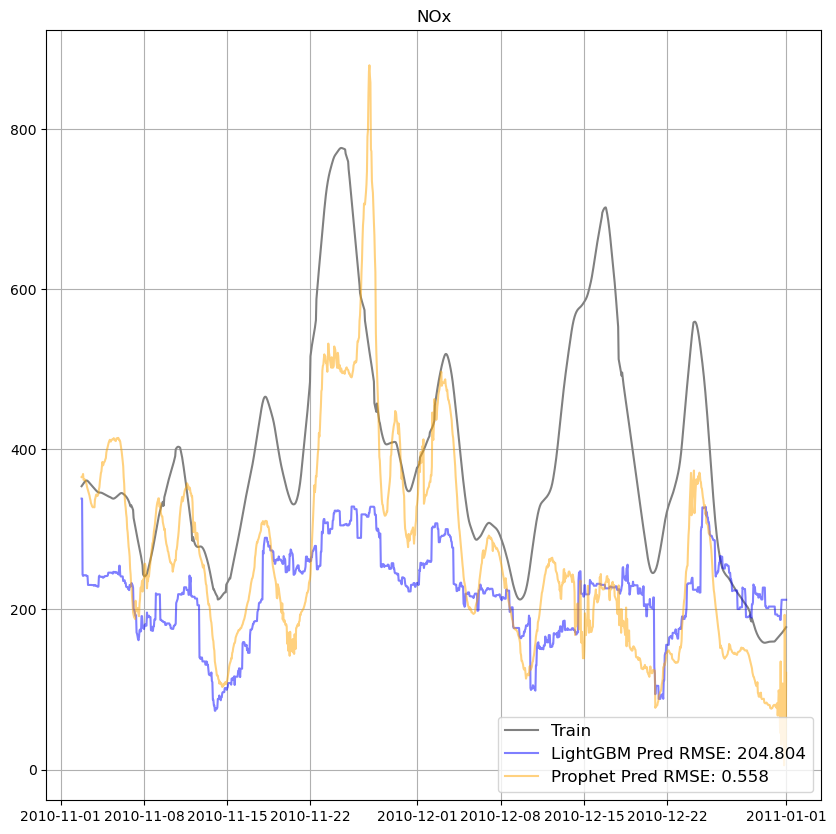

In [168]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=1, nrows=1)
plt.subplots_adjust(hspace = 0.5)

axs.plot(val_x_CO.index, np.expm1(val_y_NOx), color='gray', label='Train')
axs.plot(val_x_CO.index, val_lgb_NOx, color='blue', alpha=0.5, label=f'LightGBM Pred RMSE: {rmse_NOx:.3f}')
axs.plot(df_trend_NOx_val['ds'], np.expm1(pred_val_NOx_log.yhat), color='orange', alpha=0.5, label=f'Prophet Pred RMSE: {rmse_NOx_log:.3f}')
axs.set_title(f'{target_names[2]}')
axs.grid(axis='both')
axs.legend(loc='lower right', fontsize=12)

plt.show()